# Libraries

In [46]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

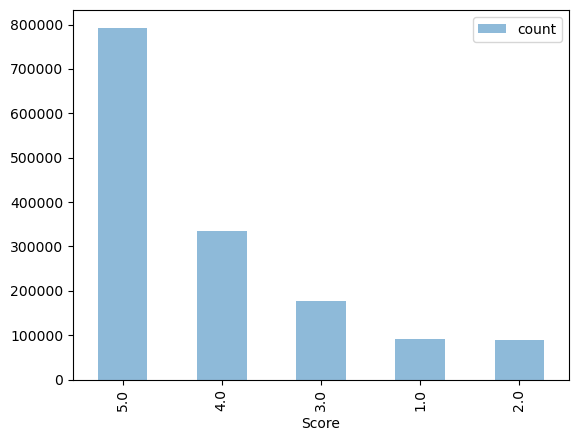


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [47]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Exploratory Analysis

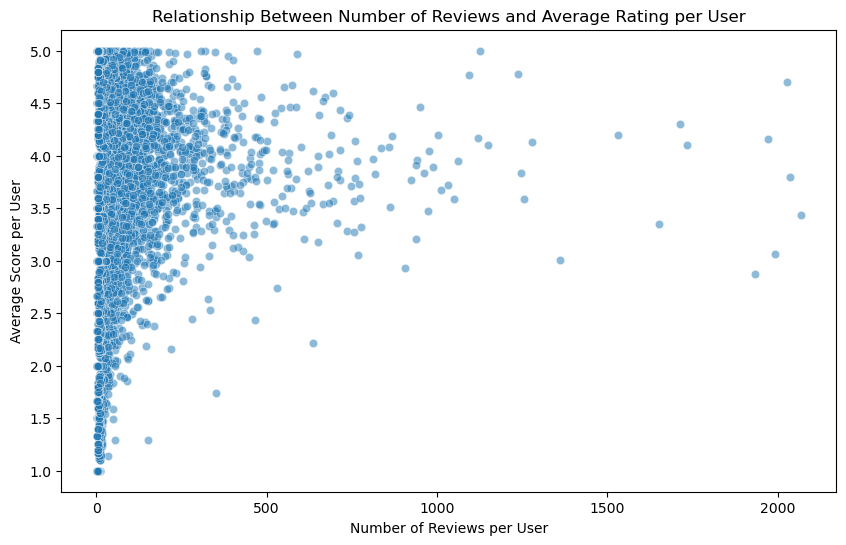

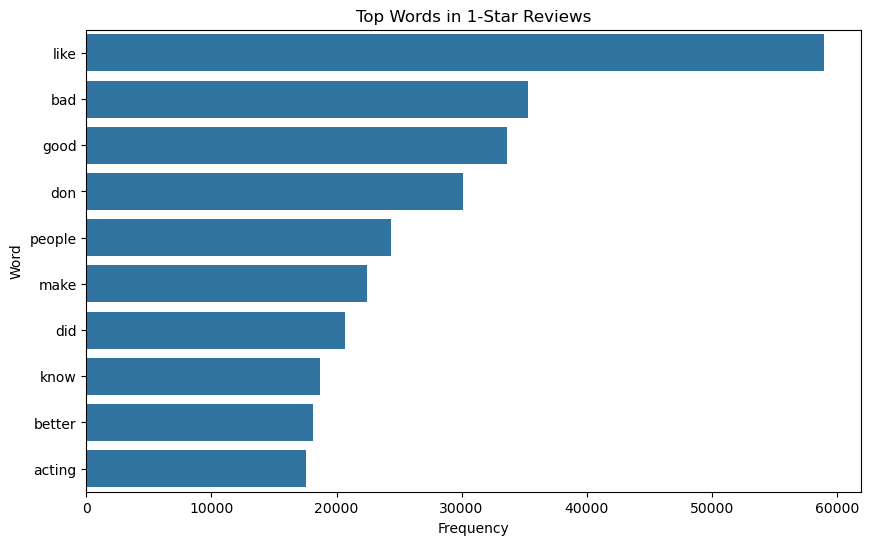

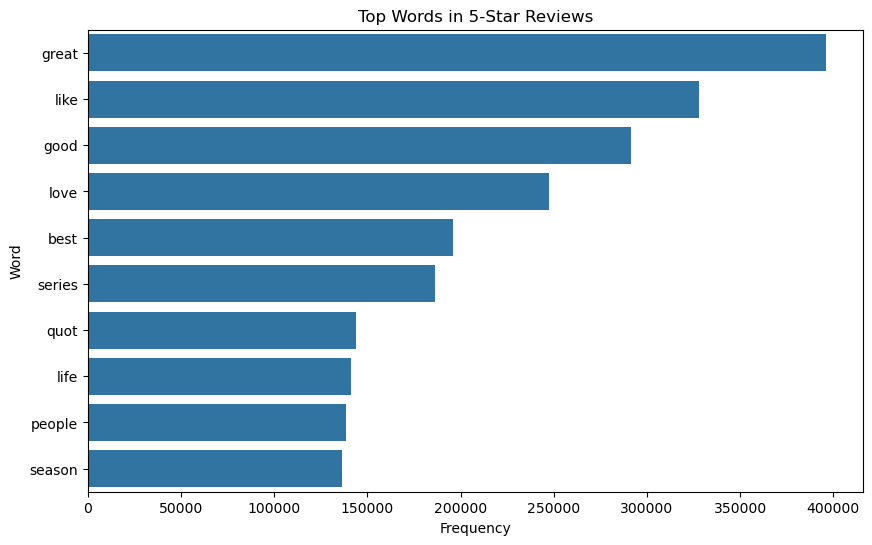

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Calculate average score per user and number of reviews per user
user_avg_score = trainingSet.groupby('UserId')['Score'].mean()
user_review_count = trainingSet.groupby('UserId')['Score'].count()

# Create a DataFrame for plotting
user_data = pd.DataFrame({
    'AverageScore': user_avg_score,
    'ReviewCount': user_review_count
}).reset_index()

# Scatter plot showing the relationship between number of reviews and average rating per user
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ReviewCount', y='AverageScore', data=user_data, alpha=0.5)
plt.title('Relationship Between Number of Reviews and Average Rating per User')
plt.xlabel('Number of Reviews per User')
plt.ylabel('Average Score per User')
plt.show()

# Find commonly used words in reviews in relation to star rating
def get_top_words_by_rating(df, rating, n_words=10):
    # Filter reviews by star rating
    reviews = df[df['Score'] == rating]['Text'].fillna('')
    
    # Initialize CountVectorizer with stop words removed and text normalization
    custom_stop_words = list(ENGLISH_STOP_WORDS.union({
        'movie', 'film', 'time', 'just', 'really', 'movies', 'dvd', 'watch', 'story', 'way'}))
    vectorizer = CountVectorizer(stop_words=custom_stop_words, max_features=1000)
    word_counts = vectorizer.fit_transform(reviews)
    
    # Sum word counts across all reviews in the rating category
    word_freq = word_counts.sum(axis=0).A1
    word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'frequency': word_freq})
    
    # Get top n most common words
    top_words = word_freq_df.nlargest(n_words, 'frequency')
    
    return top_words

# Example: Get top words for 1-star and 5-star reviews
top_words_1_star = get_top_words_by_rating(trainingSet, rating=1)
top_words_5_star = get_top_words_by_rating(trainingSet, rating=5)

# Function to create a bar plot of top words for a given star rating
def plot_top_words(top_words, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='frequency', y='word', data=top_words)
    plt.title(f'Top Words in {title}')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

# Plot top words for 1-star and 5-star ratings
plot_top_words(top_words_1_star, '1-Star Reviews')
plot_top_words(top_words_5_star, '5-Star Reviews')



# Adding Features

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Average helpfulness score per user (based on the training set)
    if 'Score' in df.columns:  # Only calculate if 'Score' is present (i.e., for training data)
        user_avg_helpfulness = df.groupby('UserId')['Helpfulness'].transform('mean')
        df['UserAvgHelpfulness'] = user_avg_helpfulness
    else:
        df['UserAvgHelpfulness'] = df['UserId'].map(user_avg_helpfulness)

    # Extract month and year from 'Time' (assuming 'Time' is in Unix format)
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['ReviewMonth'] = pd.to_datetime(df['Time'], unit='s').dt.month

    # Step 1: Generate TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    X_tfidf = tfidf_vectorizer.fit_transform(df['Text'].fillna('')).toarray()

    # Add TF-IDF features to the training set
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_feature_names)
    df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

    # Step 2: Simple Sentiment Proxy Using Positive and Negative Word Lists
    positive_words = ['great', 'excellent', 'amazing', 'love', 'wonderful', 'awesome', 'best']
    negative_words = ['bad', 'terrible', 'disappointing', 'poor', 'worst', 'awful', 'horrible']

    # Count occurrences of positive and negative words in each review
    df['PositiveWordCount'] = df['Text'].apply(
        lambda x: sum(1 for word in positive_words if pd.notnull(x) and word in x.lower()))
    df['NegativeWordCount'] = df['Text'].apply(
        lambda x: sum(1 for word in negative_words if pd.notnull(x) and word in x.lower()))

    # Create a sentiment proxy based on positive and negative word counts
    df['Sentiment'] = df['PositiveWordCount'] - df['NegativeWordCount']
    
    return df

# Process the DataFrame
train = add_features_to(trainingSet)

# Merge on Id so that the submission set can have feature columns as well
X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
X_train =  train[train['Score'].notnull()]

X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [50]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [51]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'PositiveWordCount', 'NegativeWordCount', 'Sentiment']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [52]:
# Initialize the Random Forest model
model = GradientBoostingClassifier(n_estimators=100, random_state=0)

# Fit the model on the selected training features
model.fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5602257793480837
                  Feature  Importance
5               Sentiment    0.363356
1  HelpfulnessDenominator    0.266497
2             Helpfulness    0.244437
4       NegativeWordCount    0.113924
3       PositiveWordCount    0.008752
0    HelpfulnessNumerator    0.003034


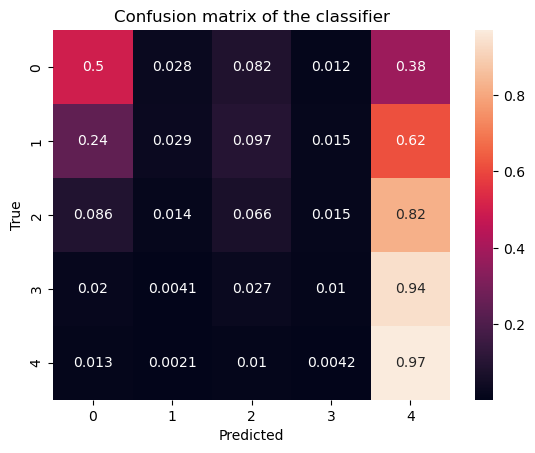

In [53]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_select.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Alternate Naive-Bayes Model

Accuracy on testing set = 0.5519098606114139


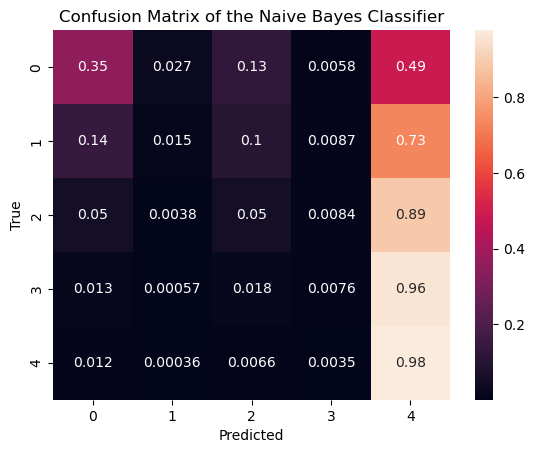

In [54]:
# Sentiment features negative vals, we need to remove it for N-Bayes model
features_nb = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'PositiveWordCount', 'NegativeWordCount']

X_train_select_nb = X_train[features_nb]
X_test_select_nb = X_test[features_nb]
X_submission_select_nb = X_submission[features_nb]

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Fit the model on the selected training features
nb_model.fit(X_train_select_nb, Y_train)

# Predict the score using the model
Y_test_predictions = nb_model.predict(X_test_select_nb)

# Evaluate model on the testing set
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix of the Naive Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [55]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)